# Emitter/Receiver Simulation with Signals

In [1]:
import numpy as np
from functools import partial

import matplotlib.pyplot as plt

#### Signal

In [2]:
from lib.TravelSignal import TravelSignal

####
from scipy.stats import norm

sample_rate = 3e2 # Hz
interp_sample_rate = sample_rate * 1/10 # Hz

t_offset = 8
periodic = False

time   = t_offset + np.arange(0, 1, 1/sample_rate) #s
time2  = t_offset + np.arange(-1.5, 1, 1/sample_rate) #s

signal = norm.pdf(time, time[len(time)//2], (time[-1] - time[0])/10)

if False:
    mysignal = TravelSignal(signal, sample_rate, t_0 = t_offset, periodic=True)
    mysignal2 = TravelSignal(signal, sample_rate, t_0 = t_offset, periodic=False)

    fig, ax = plt.subplots(1, 1, figsize=(16,4))
    ax.set_title("Raw and TravelSignal")
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time")

    ax.plot(time,   signal,                    label='Raw signal')
    ax.plot(time2,  mysignal(time2)+0.5,     '.-',     label='TravelSignal(periodic)+0.5')
    ax.plot(time2,  mysignal2(time2)-0.5,     '.-',     label='TravelSignal-0.5')

    ax.legend()

    plt.show();

## New code

In [3]:
### Location
class Location:
    """
    A location is a point designated by a spatial coordinate x.
    """

    def __init__(self, x):
        self.x = np.asarray(x)        

    def __repr__(self):
        return "Location({})".format(repr(self.x))

    def __getitem__(self, key):
        return self.x[key]

    def __setitem__(self, key, val):
        self.x[key] = val

    def __add__(self, other):
        if isinstance(other, Location):
            other = other.x

        return self.__class__(self.x + other)

    def __sub__(self, other):
        if isinstance(other, Location):
            other = other.x

        return self.__class__(self.x - other)
    
    def __eq__(self, other):
        if isinstance(other, Location):
            other = other.x

        return np.all(self.x == other)

In [4]:
### Receiver
class Receiver(Location):
    """
    A location able to trace a signal over time.
    
    Optionally applies a transformation to the traced signal.
    """
    def __repr__(self):
        return "Receiver({})".format(repr(self.x))
    
    def recv(self, travel_signal: TravelSignal) -> TravelSignal:
        """
        Return a function that traces the signal as a function of time
        at the receiver's location
        """
        return partial(travel_signal, x_f=self.x)                       

In [5]:
 ### Emitter
class Emitter(Location):
    """
    Emit a signal from position x_0 (and time t_0)
    """
    def emit(self, travel_signal: TravelSignal) -> TravelSignal:
        return partial(travel_signal, x_0=self.x)

## Testing

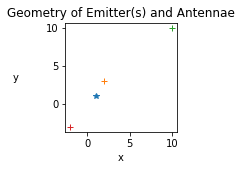

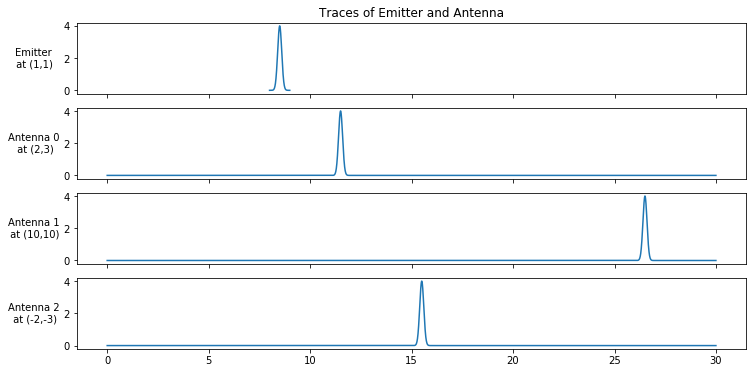

In [6]:
if True:
    sample_rate = 3e2 # Hz
    periodic = False
    
    t_offset = 8
    t_start = 0
    t_end = 1
    time   = t_offset + np.arange(t_start, t_end, 1/sample_rate) #s
    
    t_longstart = 0
    t_longend = 30*t_end
    longtime = np.arange(t_longstart, t_longend, 1/sample_rate) #s

if False:
    if True:
        freq = sample_rate/8
        signal = np.cos(2*np.pi*freq*time)
    else: 
        from scipy.stats import norm
        signal = norm.pdf(time, time[len(time)//2], (time[-1] - time[0])/10)


#####
# Setup Signal, Emitter and Antennae

mysignal = TravelSignal(signal, sample_rate, t_0 = t_offset, periodic=periodic)

source = Emitter([1,1])
emitted = source.emit(mysignal)

antennae = [
    Receiver([2,3]),
    Receiver([10,10]),
    Receiver([-2,-3]),
]
    
#####
# Follow traces, and show geometry
ylabel_kw = {"rotation": "horizontal", "va":"center", "ha":"center", "labelpad": 30}

fig, axs = plt.subplots(1,1, figsize=(2,2))
axs = [ axs ]

### Geometry Plot
i = 0
axs[i].set_title("Geometry of Emitter(s) and Antennae")
axs[i].set_ylabel("y", **ylabel_kw)
axs[i].set_xlabel("x")
axs[i].plot(*source.x, '*', label="Emitter")

for j, ant in enumerate(antennae):
    axs[i].plot(*ant.x, '+', label="Antenna {}".format(j))

### Plot Traces
fig, axs = plt.subplots(1+len(antennae),1, sharex=True, figsize=(12,6))
axs[0].set_title("Traces of Emitter and Antenna")

# Emitter
i = 0
axs[i].set_ylabel("Emitter\n at ({},{})".format(*source.x), **ylabel_kw)
axs[i].plot(time, emitted(time))

# Antenna
for j, ant in enumerate(antennae):
    i +=1
    axs[i].set_ylabel("Antenna {}\n at ({},{})".format(j, *ant.x), **ylabel_kw)
    axs[i].plot(longtime, ant.recv(emitted)(longtime), label="Antenna {}".format(j))
    